## Licitación
### 1. Duplicados

In [1]:
import pandas as pd
import time

pd.set_option('display.max_columns', None)

#### Leyendo el CSV de licitación y convirtiéndolo a parquet para manejar un formato más eficiente

In [2]:
start_time = time.time()

# Read CSV and save to Parquet
licitacion_df = pd.read_csv('../../data/Processed/All_Tables_Raw/licitacion_data_Raw.csv')
licitacion_df.to_parquet('../../data/Processed/parquet_files/licitacion_data.parquet')

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Tiempo de ejecución: 35.99360752105713 segundos


#### Leyendo el archivo parquet de licitación y mostrando los primeros rows

In [3]:
start_time = time.time()

# Read from Parquet (faster and uses less memory)
licitacion_df = pd.read_parquet('../../data/Processed/parquet_files/licitacion_data.parquet')

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")
licitacion_df.head()

Tiempo de ejecución: 7.744154453277588 segundos


,cve_expediente,procurementMethod,procurementMethod_rationale,status,title,description,has_enquiries,number_tenderers,tender_start_date,tender_end_date,award_start_date,award_end_date,enquiry_start_date,enquiry_end_date,procuring_entity_id,procuring_entity_name,value_currency_tender,value_amount_tender,award_criteria,framework_agreement,framework_agreement_platform,framework_agreement_title,submission_method
0,1892834,direct,Art. 41 fr. V,complete,SERVICIOS MEDICOS SUBROGADOS DE ESPECIALIZACIO...,SERVICIOS MEDICOS SUBROGADOS DE ESPECIALIZACIO...,False,0,2021-09-28T16:39:00Z,None,None,2019-03-19T00:00:00Z,2021-09-28T16:39:00Z,None,ISS6001015A3-051GYN085,ISSSTE-Hospital Regional Gral. Ignacio Zaragoz...,None,NaN,None,None,None,None,electronicSubmission
1,2010079,direct,Art. 41 fr. XIV,complete,TALLER CULTURAL DE YOGA PARA JUBILADOS Y PENSI...,TALLER CULTURAL DE YOGA PARA JUBILADOS Y PENSI...,False,0,2021-09-09T12:08:00Z,None,None,2019-09-01T00:00:00Z,2021-09-09T12:08:00Z,None,ISS6001015A3-051GYN035,"ISSSTE-Delegación Tabasco, Subdelegación de Ad...",None,NaN,None,None,None,None,inPerson
2,2039835,direct,Art. 41 fr. III,complete,SD_TGM_12122019 SUMINISTRO DE 301 MONEDEROS EL...,SD_TGM_12122019 SUMINISTRO DE 301 MONEDEROS EL...,False,0,2021-09-24T11:17:00Z,None,None,2019-12-18T00:00:00Z,2021-09-24T11:17:00Z,None,TGM990109718-004E2D001,TGM-Gerencia de Abastecimientos #004E2D001,None,NaN,None,None,None,None,electronicSubmission
3,2058673,direct,Art. 41 fr. II,complete,SERVICIO DE LIMPIEZA,Contrato celebrado para brindar el servicio de...,False,0,2021-09-03T10:46:00Z,None,None,2020-01-31T00:00:00Z,2021-09-03T10:46:00Z,None,RAN920810MU6-015B00973,RAN-Delegación Chihuahua #015B00973,None,NaN,None,None,None,None,inPerson
4,2071481,direct,Art. 41 fr. XIV,complete,SERVICIOS PROFESIONALES,SERVICIOS PROFESIONALES,False,0,2021-09-02T13:49:00Z,None,None,2020-01-16T00:00:00Z,2021-09-02T13:49:00Z,None,INI080202BQ8-011MDE001,INIFED-Gerencia de Recuros Materiales y Servic...,None,NaN,None,None,None,None,inPerson


In [4]:
licitacion_df.shape

(2742267, 23)

In [5]:
licitacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742267 entries, 0 to 2742266
Data columns (total 23 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   cve_expediente                int64  
 1   procurementMethod             object 
 2   procurementMethod_rationale   object 
 3   status                        object 
 4   title                         object 
 5   description                   object 
 6   has_enquiries                 bool   
 7   number_tenderers              int64  
 8   tender_start_date             object 
 9   tender_end_date               object 
 10  award_start_date              object 
 11  award_end_date                object 
 12  enquiry_start_date            object 
 13  enquiry_end_date              object 
 14  procuring_entity_id           object 
 15  procuring_entity_name         object 
 16  value_currency_tender         object 
 17  value_amount_tender           float64
 18  award_criteria        

#### Estadísticas descriptivas para todas las variables

In [6]:
licitacion_df = licitacion_df.astype({
    'cve_expediente': 'string'})

# Obtener estadísticas descriptivas para todas las variables
descriptive_stats = licitacion_df.describe(include='all').transpose()

# Mostrar las estadísticas descriptivas
descriptive_stats

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cve_expediente,2742267,567053,1892834,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procurementMethod,2742091,3,direct,2288149,NaN,NaN,NaN,NaN,NaN,NaN,NaN
procurementMethod_rationale,2454889,38,Art. 42 párrafo primero,845662,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,2742267,3,complete,2601467,NaN,NaN,NaN,NaN,NaN,NaN,NaN
title,2742267,304415,HARINA DE MAIZ,50878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,2709225,332321,COMPRA PARA ATENDER REQUERIMIENTOS DEL PROGRAM...,178101,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_enquiries,2742267,1,False,2742267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
number_tenderers,2742267.0,NaN,NaN,NaN,1.163731,4.110223,0.0,0.0,0.0,0.0,135.0
tender_start_date,2742267,420788,2021-10-11T13:34:00Z,194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tender_end_date,454623,20823,2021-10-25T10:00:00Z,1179,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### ¿Cuántos expedientes se repiten "x" número de veces"?

In [7]:
# Step 1: Count the repetitions of each `cve_expediente`
repetition_counts = licitacion_df.groupby('cve_expediente').size().reset_index(name='repetition_count')
repetition_counts.sort_values(by='repetition_count', ascending=False)

,cve_expediente,repetition_count
350201,2187063,28
294787,2095206,28
295138,2095757,28
320863,2138888,28
308764,2116895,28
...,...,...
189045,1923678,1
189044,1923675,1
189043,1923674,1
189042,1923672,1


In [8]:
# Step 2: Count the occurrences of these repetition counts
repetition_summary = repetition_counts['repetition_count'].value_counts().reset_index()
repetition_summary.columns = ['repetition_count', 'file_count']
repetition_summary.head()

,repetition_count,file_count
0,1,421986
1,25,14604
2,24,13654
3,19,13460
4,4,10242


In [10]:
# Step 3: Sort the summary DataFrame by `repetition_count`
repetition_summary = repetition_summary.sort_values(by='repetition_count').reset_index(drop=True)
repetition_summary.head(10)

# Ejemplo de lectura del dataframe:
# * 7776 expedientes se repiten 2 veces
# * 74 expedientes se repiten 3 veces... así sucesivamente

,repetition_count,file_count
0,1,421986
1,2,7776
2,3,74
3,4,10242
4,5,99
5,6,5440
6,7,9950
7,8,348
8,9,7014
9,10,556


Mostrando los resultados en una gráfica (A partir de 2 repeticiones)

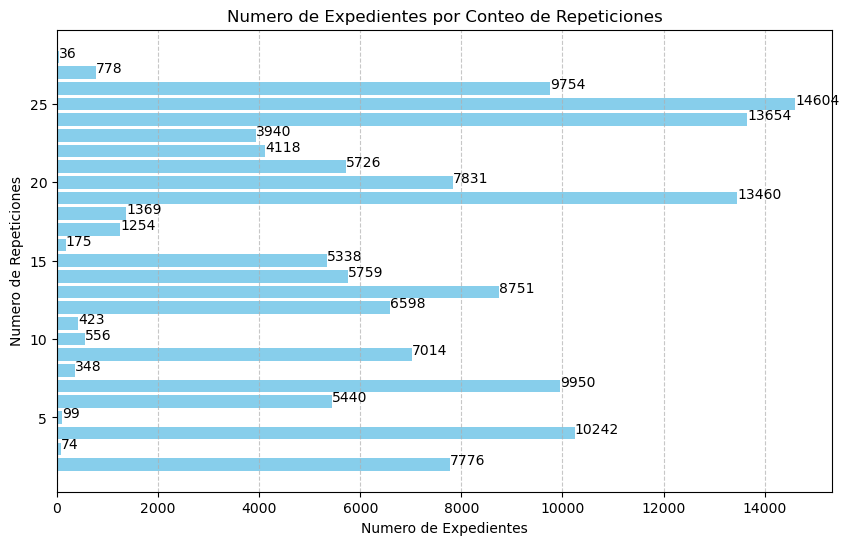

In [11]:
import matplotlib.pyplot as plt


# Exclude the first row of the DataFrame
repetition_summary_filtered = repetition_summary.iloc[1:]

# Plotting the horizontal bar graph
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.barh(repetition_summary_filtered['repetition_count'], repetition_summary_filtered['file_count'], color='skyblue')
plt.xlabel('Numero de Expedientes')
plt.ylabel('Numero de Repeticiones')
plt.title('Numero de Expedientes por Conteo de Repeticiones')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Annotating the bars with the count values
for index, value in enumerate(repetition_summary_filtered['file_count']):
    plt.text(value, repetition_summary_filtered['repetition_count'].iloc[index], str(value))

plt.show()

### 1.1 Expedientes con más de un award_end_date

#### Convirtiendo award_end_date a tipo datetime

In [12]:
# Assuming licitacion_df is your DataFrame and 'award_end_date' is the column with the ISO 8601 dates
licitacion_df['award_end_date'] = pd.to_datetime(licitacion_df['award_end_date'], errors='coerce')

# Check for any entries where dates could not be parsed
invalid_dates = licitacion_df[licitacion_df['award_end_date'].isna()]
if not invalid_dates.empty:
    print("Entries with invalid dates:")
    print(invalid_dates.shape)
else:
    print("All dates converted successfully.")

Entries with invalid dates:
(586, 23)


In [13]:
licitacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742267 entries, 0 to 2742266
Data columns (total 23 columns):
 #   Column                        Dtype              
---  ------                        -----              
 0   cve_expediente                string             
 1   procurementMethod             object             
 2   procurementMethod_rationale   object             
 3   status                        object             
 4   title                         object             
 5   description                   object             
 6   has_enquiries                 bool               
 7   number_tenderers              int64              
 8   tender_start_date             object             
 9   tender_end_date               object             
 10  award_start_date              object             
 11  award_end_date                datetime64[ns, UTC]
 12  enquiry_start_date            object             
 13  enquiry_end_date              object             
 14  pr

#### Priorizando la fecha más reciente para cada expediente
Si hay más de una fila con la fecha más reciente conservamos todas las filas con esa fecha para después priorizar por status.

In [14]:
# Sort the DataFrame by 'cve_expediente' and 'award_end_date' descending
sorted_df = licitacion_df.sort_values(by=['cve_expediente', 'award_end_date'], ascending=[True, False])

# Get the most recent date for each `cve_expediente`
most_recent_dates = sorted_df.groupby('cve_expediente')['award_end_date'].max().reset_index()

# Merge to get only the rows with the most recent `award_end_date`
merged_df = pd.merge(sorted_df, most_recent_dates, on=['cve_expediente', 'award_end_date'], how='inner')

# Optionally, check the shape of the DataFrame
print("DataFrame shape after keeping the most recent dates:", merged_df.shape)

# Display the first few rows of the cleaned DataFrame to verify
merged_df.head()

DataFrame shape after keeping the most recent dates: (2705310, 23)


,cve_expediente,procurementMethod,procurementMethod_rationale,status,title,description,has_enquiries,number_tenderers,tender_start_date,tender_end_date,award_start_date,award_end_date,enquiry_start_date,enquiry_end_date,procuring_entity_id,procuring_entity_name,value_currency_tender,value_amount_tender,award_criteria,framework_agreement,framework_agreement_platform,framework_agreement_title,submission_method
0,1004872,direct,Art. 42 párrafo primero,complete,MANTENIMIENTO AL PARQUE VEHICULAR DE OFICINA C...,MANTENIMIENTOPREVENTIVO Y CORRECTIVO AL PARQUE...,False,6,2016-02-22T13:31:00Z,None,None,2016-02-25 00:00:00+00:00,2016-02-22T13:31:00Z,None,LlC960821M84-008VST977,LICONSA-Gerencia de Recursos Materiales y Serv...,None,NaN,None,None,None,None,electronicSubmission
1,1016499,direct,Art. 42 párrafo segundo,complete,SERVICIO LEGALES,"SERVICIO DE ASUNTOS LABORALES, REVISIÓN JURÍDI...",False,0,2016-03-08T12:18:00Z,None,None,2015-12-29 00:00:00+00:00,2016-03-08T12:18:00Z,None,LlC960821M84-008VST977,LICONSA-Gerencia de Recursos Materiales y Serv...,None,NaN,None,None,None,None,inPerson
2,1036167,direct,Art. 42 párrafo primero,complete,ASEGURAMIENTO DE BIENES MUEBLES E INMUEBLES DE...,None,False,0,2016-05-09T14:00:00Z,None,None,2016-02-23 00:00:00+00:00,2016-05-09T14:00:00Z,None,IAA6210025R4-006A00996,INDAABIN-Unidad de Administración y Finanzas #...,None,NaN,None,None,None,None,inPerson
3,1047535,direct,Art. 42 párrafo primero,complete,AGUAS RESIDUALES,None,False,1,2016-04-22T15:02:00Z,None,None,2016-04-25 00:00:00+00:00,2016-04-22T15:02:00Z,None,CIE6010281U2-011L4J995,CINVESTAV-Subdirección de Recursos Materiales ...,None,NaN,None,None,None,None,written
4,1048041,direct,Art. 42 párrafo primero,complete,ALIMENTO PARA ROEDOR,ADQUISICIÓN DEL SUMINISTRO DE ALIMENTO PARA LO...,False,0,2016-04-25T19:04:00Z,None,None,2016-04-28 00:00:00+00:00,2016-04-25T19:04:00Z,None,HIM871203BS0-012NBG001,HIM-Departamento de Adquisiciones Generales #0...,None,NaN,None,None,None,None,electronicSubmission


### 1.2 Expedientes con más de un status

#### Mostrando valores únicos de status

In [15]:
# Display all distinct status values from the original DataFrame
distinct_statuses = merged_df['status'].unique()
print("Distinct Statuses Across DataFrame:")
print(distinct_statuses)

Distinct Statuses Across DataFrame:
['complete' 'unsuccessful' 'active']


#### Identificando expedientes con más de un status: 12,962 

In [16]:
# Aggregate the unique statuses for each cve_expediente
agg_df = merged_df.groupby('cve_expediente')['status'].agg(lambda x: list(set(x))).reset_index()

# Filter for cve_expediente with more than one distinct status
multiple_statuses_df = agg_df[agg_df['status'].apply(len) > 1]

# Display the cve_expediente with multiple statuses
print("CVE Expediente with Multiple Statuses:")
multiple_statuses_df.head(10)

CVE Expediente with Multiple Statuses:


,cve_expediente,status
381492,2241434,"[active, complete]"
391254,2256332,"[active, complete]"
400328,2271214,"[active, complete]"
403816,2277768,"[active, unsuccessful]"
403885,2277905,"[active, complete]"
407460,2284319,"[active, complete]"
408201,2285562,"[active, complete]"
410276,2289139,"[active, complete]"
410317,2289235,"[active, complete]"
410703,2289956,"[active, complete]"


#### Limpiando duplicados por status

In [17]:
start_time = time.time()

# Define a custom sort key based on status priority
status_priority = {'complete': 1, 'unsuccessful': 2, 'active': 3}
merged_df['status_priority'] = merged_df['status'].map(status_priority)

# Sort the DataFrame by 'cve_expediente' and 'status_priority'
sorted_df = merged_df.sort_values(by=['cve_expediente', 'status_priority'])

# Drop duplicates, keeping the first entry (highest priority status) for each 'cve_expediente'
cleaned_df = sorted_df.drop_duplicates(subset='cve_expediente', keep='first')

# drop the 'status_priority' column as it's no longer needed
cleaned_df = cleaned_df.drop(columns=['status_priority'])

# Display the cleaned DataFrame
print(cleaned_df.shape)

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

(567053, 23)
Tiempo de ejecución: 3.2350289821624756 segundos


#### Confirmando 0 expedientes con más de un status

In [18]:
# Aggregate the unique statuses for each cve_expediente
agg_df = cleaned_df.groupby('cve_expediente')['status'].agg(lambda x: list(set(x))).reset_index()

# Filter for cve_expediente with more than one distinct status
multiple_statuses_df = agg_df[agg_df['status'].apply(len) > 1]

# Display the cve_expediente with multiple statuses
print("CVE Expediente with Multiple Statuses:")
multiple_statuses_df

CVE Expediente with Multiple Statuses:


,cve_expediente,status


In [20]:
cleaned_df.to_csv('../../data/Cleaned/cleaned_licitacion_data.csv', index=False, encoding='utf-8')

print("DataFrame has been saved to 'cleaned_licitacion_data.csv'")

DataFrame has been saved to 'cleaned_licitacion_data.csv'


## 2. Asignación

#### Leyendo el CSV de Asignación y convirtiéndolo a parquet para manejar un formato más eficiente

In [22]:
start_time = time.time()

# Read CSV and save to Parquet
asignacion_df = pd.read_csv('../../data/Processed/All_Tables_Raw/asignacion_data_Raw.csv')
asignacion_df.to_parquet('../../data/Processed/parquet_files/asignacion_data.parquet')

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Tiempo de ejecución: 42.67133378982544 segundos


#### Leyendo el archivo parquet de Asignación y mostrando los primeros rows

In [23]:
start_time = time.time()

# Read from Parquet (faster and uses less memory)
asignacion_df = pd.read_parquet('../../data/Processed/parquet_files/asignacion_data.parquet')

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")
asignacion_df.head()

Tiempo de ejecución: 9.273965120315552 segundos


,cve_expediente,cve_contrato,status,description_award,title_award,contract_start_date,contract_end_date,value_amount,value_currency,suppliers_id,suppliers_name,docs_url_awards,docs_title_awards,docs_language_awards,docs_id_awards,docs_format_awards,docs_type_awards,docs_descr_awards,docs_date_published_awards
0,1892834,2038777,active,SERVICIOS MEDICOS SUBROGADOS DE ESPECIALIZACIO...,SERVICIOS MEDICOS SUBROGADOS DE ESPECIALIZACIO...,2019-03-19T00:00:00Z,2019-06-30T23:59:00Z,150000.00,MXN,04B3DC027ADD775B746959A20A80292A,"APLICACIONES INDUSTRIALES DE CALIDAD, S.A. DE ...",None,None,None,NaN,None,None,None,None
1,2010079,2186605,active,TALLER CULTURAL DE YOGA PARA JUBILADOS Y PENSI...,TALLER CULTURAL DE YOGA PARA JUBILADOS Y PENSI...,2019-09-01T00:00:00Z,2019-12-31T23:59:00Z,12068.80,MXN,5BECD127FEA6806B2A404D2B14A9CEEE,LEONOR HILDA BARRIOS SANCHEZ,None,None,None,NaN,None,None,None,None
2,2039835,2591875,active,SUMINISTRO DE 301 MONEDEROS ELECTRÓNICOS,SUMINISTRO DE 301 MONEDEROS ELECTRÓNICOS,2019-12-18T09:00:00Z,2019-12-20T12:59:00Z,3625000.00,MXN,TIN090211JC9,TOKA INTERNACIONAL S A P I DE CV,None,None,None,NaN,None,None,None,None
3,2058673,2248316,active,CONTRATO CELEBRADO PARA EL SERVICIO DE LIMPIEZ...,Servicio de Limpieza,2020-02-02T00:00:00Z,2020-12-31T23:59:00Z,251900.00,MXN,3CEDE48206129D952B3EA0B6EA3E093D,PATRICIA SELENE SOLIS GALLEGOS,None,None,None,NaN,None,None,None,None
4,2071481,2264071,active,SERVICIOS PROFESIONALES,SERVICIOS PROFESIONALES,2020-01-16T09:00:00Z,2020-04-30T18:00:00Z,64870.68,MXN,AAB6B3F29F29293964209B17E7D72DAC,LUIS ALBERTO ESPINOZA VAZQUEZ,None,None,None,NaN,None,None,None,None


In [24]:
asignacion_df.shape

(4163085, 19)

In [25]:
asignacion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4163085 entries, 0 to 4163084
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   cve_expediente              int64  
 1   cve_contrato                int64  
 2   status                      object 
 3   description_award           object 
 4   title_award                 object 
 5   contract_start_date         object 
 6   contract_end_date           object 
 7   value_amount                float64
 8   value_currency              object 
 9   suppliers_id                object 
 10  suppliers_name              object 
 11  docs_url_awards             object 
 12  docs_title_awards           object 
 13  docs_language_awards        object 
 14  docs_id_awards              float64
 15  docs_format_awards          object 
 16  docs_type_awards            object 
 17  docs_descr_awards           object 
 18  docs_date_published_awards  object 
dtypes: float64(2), int64(

### 2.1 Removiendo duplicados al priorizar la fecha más reciente de contract_start_date         

In [26]:
# Step 1: Convert 'contract_start_date' to datetime
asignacion_df['contract_start_date'] = pd.to_datetime(asignacion_df['contract_start_date'], errors='coerce')

# Step 2: Sort the DataFrame by 'cve_contrato' and 'contract_start_date' in descending order
asignacion_df = asignacion_df.sort_values(by=['cve_contrato', 'contract_start_date'], ascending=[True, False])

# Step 3: Drop duplicates based on 'cve_contrato', keeping the first occurrence
asignacion_df = asignacion_df.drop_duplicates(subset='cve_contrato', keep='first')

# Optionally, check the shape of the DataFrame
print("DataFrame shape after removing duplicates:", asignacion_df.shape)

# Display the first few rows of the cleaned DataFrame to verify
asignacion_df.head()

DataFrame shape after removing duplicates: (828542, 19)


,cve_expediente,cve_contrato,status,description_award,title_award,contract_start_date,contract_end_date,value_amount,value_currency,suppliers_id,suppliers_name,docs_url_awards,docs_title_awards,docs_language_awards,docs_id_awards,docs_format_awards,docs_type_awards,docs_descr_awards,docs_date_published_awards
591239,975480,964520,active,"CONTRATO PLURIANUAL 2015 ¿ 2018, BAJO LA MODAL...",SERVICIO INTEGRAL DE ARRENDAMIENTO DE EQUIPO D...,2015-06-01 00:00:00+00:00,2018-05-31T23:59:00Z,8474040.00,MXN,TPL030219RE3,TEC PLUSS SA DE CV,None,None,None,NaN,None,None,None,None
10457,1016499,1019413,active,"SERVICIO DE ATENCIÓN DE ASUNTOS LABORALES, REV...",SERVICIOS DE ASESORÍA JURÍDICA,2016-01-01 00:00:00+00:00,2016-12-31T23:59:00Z,2844000.00,MXN,VAB140128J79,VERNIS ABOGADOS SC,None,None,None,NaN,None,None,None,None
10455,1004872,1025677,active,MANTENIMIENTO PREVENTIVO Y CORRECTIVO DEL PARQ...,MANTENIMIENTO PREVENTIVO Y CORRECTIVO AL PARQU...,2016-02-29 17:01:00+00:00,2016-12-31T12:00:00Z,650000.02,MXN,ASI941004139,AUTOMOTRIZ Y SERVICIO INTEGRAL SA DE CV,None,None,None,NaN,None,None,None,None
10459,1036167,1043633,active,None,"AGROASEMEX, S.A.",2016-03-01 00:00:00+00:00,2016-12-31T23:59:00Z,3159900.00,MXN,AGR900605VC6,"AGROASEMEX, S.A.",None,None,None,NaN,None,None,None,None
10464,1057507,1070559,active,"Servicios informáticos de adecuación, mantenim...","Servicios informáticos de adecuación, mantenim...",2017-01-01 09:00:00+00:00,2017-02-28T23:59:00Z,201116.60,MXN,CSB080408DB8,CONSULTORES Y SOLUCIONES BAJAWARE S DE RL DE CV,None,None,None,NaN,None,None,None,None


#### Save the cleaned DataFrame to a CSV file

In [27]:
asignacion_df.to_csv('../../data/Cleaned/cleaned_asignacion_data.csv', index=False, encoding='utf-8')

print("DataFrame has been saved to 'cleaned_asignacion_data.csv'")

DataFrame has been saved to 'cleaned_asignacion_data.csv'


### 3. Documentos Tender
### Duplicados por docs_date_published

#### Leyendo el CSV de licitación y convirtiéndolo a parquet para manejar un formato más eficiente

In [29]:
# Read CSV and save to Parquet
documentos_df = pd.read_csv('../../data/Processed/All_Tables_Raw/documentos_tender_data_V2_Raw.csv')
documentos_df.to_parquet('../../data/Processed/parquet_files/documentos_tender_data_V2_Raw.parquet')

elapsed_time = time.time() - start_time
print(f"Tiempo de ejecución: {elapsed_time} segundos")

Tiempo de ejecución: 483.76718306541443 segundos


In [30]:
documentos_df.shape

(840404, 9)

In [31]:
documentos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840404 entries, 0 to 840403
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   cve_expediente              840404 non-null  int64 
 1   docs_title_tender           840404 non-null  object
 2   docs_type_tender            840404 non-null  object
 3   docs_language_tender        840404 non-null  object
 4   docs_date_published_tender  840404 non-null  object
 5   docs_id_tender              840404 non-null  int64 
 6   docs_format_tender          840404 non-null  object
 7   docs_description_tender     840404 non-null  object
 8   docs_url_tender             840404 non-null  object
dtypes: int64(2), object(7)
memory usage: 57.7+ MB


#### Limpiando duplicados al priorizar la primera fecha (fecha más antigua) de docs_date_published_tender

In [32]:
# Asegurarte de que la columna de fecha esté en el formato datetime
documentos_df['docs_date_published_tender'] = pd.to_datetime(documentos_df['docs_date_published_tender'])

# Ordenar el DataFrame por la fecha de publicación en orden ascendente
documentos_df = documentos_df.sort_values(by='docs_date_published_tender', ascending=True)

# Eliminar duplicados y mantener el primer registro de cada grupo basado en 'cve_expediente'
documentos_df = documentos_df.drop_duplicates(subset='cve_expediente', keep='first')

# Verificar el resultado
print(documentos_df.shape)
documentos_df.head()

(91899, 9)


,cve_expediente,docs_title_tender,docs_type_tender,docs_language_tender,docs_date_published_tender,docs_id_tender,docs_format_tender,docs_description_tender,docs_url_tender
3198,1189249,Conv-IO-009000960-E43-2016.doc,tenderNotice,es,2016-10-25 19:52:00+00:00,29197598,text/html,Convocatoria / Invitación,https://compranet.hacienda.gob.mx/esop/guest/g...
3200,1189263,Conv-IO-009000960-E44-2016.doc,tenderNotice,es,2016-10-25 20:35:00+00:00,29198348,text/html,Convocatoria / Invitación,https://compranet.hacienda.gob.mx/esop/guest/g...
3266,1246041,2017.docx,tenderNotice,es,2017-01-02 15:35:00+00:00,30046494,text/html,Convocatoria / Invitación,https://compranet.hacienda.gob.mx/esop/guest/g...
3268,1246227,2017.docx,tenderNotice,es,2017-01-02 18:24:00+00:00,30047451,text/html,Convocatoria / Invitación,https://compranet.hacienda.gob.mx/esop/guest/g...
3263,1242820,Convocatoria LPN GASES MEDICINALES.docx,tenderNotice,es,2017-01-03 09:07:00+00:00,30049859,text/html,Convocatoria / Invitación,https://compranet.hacienda.gob.mx/esop/guest/g...


#### Limpiando duplicados al priorizar la primera fecha (fecha más antigua) de docs_date_published_tender

In [33]:
documentos_df.to_csv('../../data/Cleaned/cleaned_documentos_tender_data_V2_Raw.csv', index=False, encoding='utf-8')

print("DataFrame has been saved to 'cleaned_documentos_tender_data_V2_Raw.csv'")

DataFrame has been saved to 'cleaned_documentos_tender_data_V2_Raw.csv'
